# Description

This notebook is used for training the DrowsinessModel (defined in model.py) to detect if a driver is tending to fall asleep. Post training evaluations are also done after training.

# Imports

In [31]:
import torch, os, tqdm
from model import DrowsinessModel
from dataset import DrowsinessDataset
from torch.nn import CrossEntropyLoss
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, numpy as np

# Initializations and Hyperparameters

### Initializations

In [2]:
ANNOTATIONS_PATH = 'dataset_annotations.json'
TRAIN_FRACTION = 0.8

### Model Parameters

In [3]:
IN_CHANNELS = 3
OUT_CHANNELS = 4
FEATURES = [16, 32]

### Training Parameters

In [4]:
EPOCHS = 15
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-6
BATCH_SIZE = 32

# Prerequisites

### Loading dataset

In [5]:
transform = transforms.Compose([
    transforms.Resize((145, 145)),
    transforms.ToTensor(), 
])

In [6]:
full_dataset = DrowsinessDataset(ANNOTATIONS_PATH, transform=transform)
len(full_dataset)

2896

In [7]:
train_size = int(TRAIN_FRACTION*len(full_dataset))
test_size = len(full_dataset)-train_size
train_size, test_size

(2316, 580)

In [8]:
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [10]:
for feature, target in train_loader:
    print(feature.shape, target.shape)
    break

torch.Size([32, 3, 145, 145]) torch.Size([32, 4])


In [11]:
feature.dtype

torch.float32

### Model

In [12]:
model = DrowsinessModel(in_channel=IN_CHANNELS, out_channel=OUT_CHANNELS, features=FEATURES)
model

DrowsinessModel(
  (conv_layers): ModuleList(
    (0): ConvPiece(
      (conv): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvPiece(
      (conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=41472, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)

# Training

### Prerequisities

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):

    running_loss = 0
    last_loss = 0

    for i, data in enumerate(dataloader):

        feature, target = data
        feature = feature.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        predictions = model(feature)

        loss = loss_fn(predictions, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1)%5==0:
            last_loss = running_loss/5
            print(f'Batch {i+1},  loss: {last_loss}')
            running_loss=0
    return last_loss




In [15]:
def train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs):

    model = model.to(device)

    for epoch in range(epochs):
        
        print(f"EPOCH {epoch+1}")

        model.train(True)

        avg_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)

        running_val_loss = 0.0

        model.eval()

        with torch.no_grad():

            for i, vdata in enumerate(val_loader):
              vfeature, vtarget = vdata
              vfeature=vfeature.to(device)
              vtarget=vtarget.to(device)
              vpredictions = model(vfeature)

              vloss = loss_fn(vpredictions, vtarget)
              running_val_loss+=vloss
            avg_vloss = running_val_loss/(i+1)
        
        print(f'LOSS train {avg_loss}. Validation loss: {avg_vloss} \n\n')

        
        checkpoint = {
                'epoch': epoch,  
                'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'avg_loss':avg_loss,
                'avg_vloss':avg_vloss
               
                   }
           
        if not os.path.exists("./checkpoints"):
              os.mkdir("checkpoints")

        torch.save(checkpoint, f'./checkpoints/checkpoint_{epoch+1}.pth')



        


In [16]:
optimizer = torch.optim.Adam(lr=LEARNING_RATE, params=model.parameters(), weight_decay=WEIGHT_DECAY)
loss_fn = CrossEntropyLoss()

In [ ]:
train(model, train_loader, test_loader, loss_fn, optimizer, device, EPOCHS)

# Evaluation: Loss trend, Accuracy, F1-score

In [21]:
checkpoint_dir = "./checkpoints"

### Loss trend

In [19]:
epochs = []
train_losses = []
val_losses = []

In [22]:
checkpoint_files = sorted([
    f for f in os.listdir(checkpoint_dir)
    if f.endswith(".pth") and f.startswith("checkpoint_")
], key=lambda x: int(x.split("_")[1].split(".")[0]))

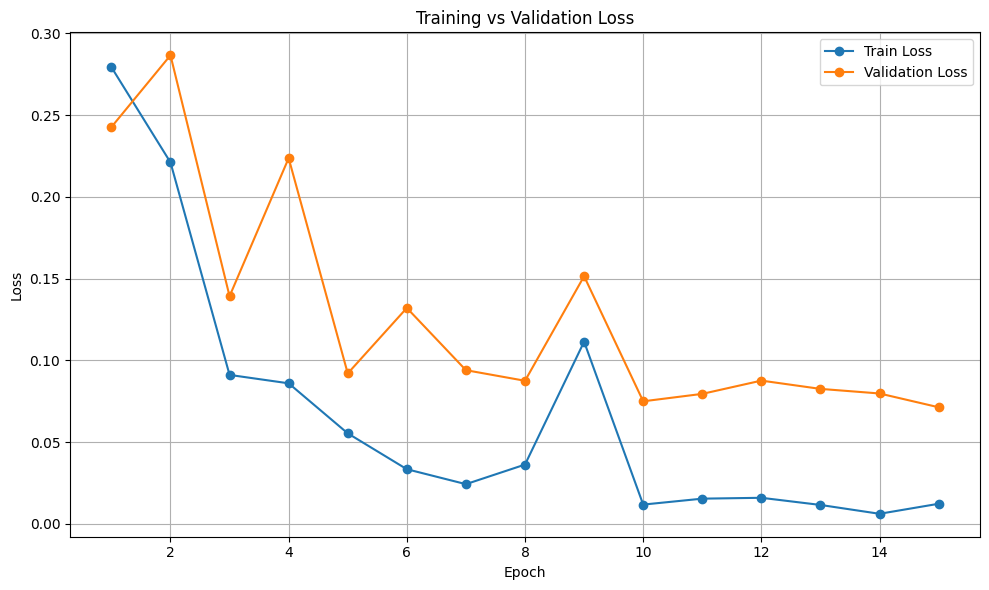

In [23]:
for ckpt_file in checkpoint_files:
    path = os.path.join(checkpoint_dir, ckpt_file)
    checkpoint = torch.load(path, map_location='cpu')
    
    epoch = checkpoint['epoch'] + 1  
    train_loss = checkpoint['avg_loss']
    val_loss = checkpoint['avg_vloss']
    
    epochs.append(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Accuracy

In [28]:
def evaluate_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm.tqdm(test_loader):
            images = images.to(device)
            targets = targets.to(device)

           
            outputs = model(images)  
            predicted = torch.argmax(outputs, dim=1)
            labels = torch.argmax(targets, dim=1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100.0 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")
    return accuracy

In [29]:
evaluate_accuracy(model, test_loader, device)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 23.88it/s]

Accuracy on test set: 97.93%


97.93103448275862

### Precision, Recall, F1-score and Confusion Matrix

In [34]:
def evaluate_classification_metrics(model, test_loader, device, class_names=None):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets in tqdm.tqdm(test_loader):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            labels = torch.argmax(targets, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

  
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

 
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return cm

100%|██████████| 19/19 [00:00<00:00, 20.88it/s]


Classification Report:
               precision    recall  f1-score   support

   yawn_faces       0.99      0.99      0.99       155
no_yawn_faces       0.99      0.99      0.99       153
       Closed       0.95      0.98      0.97       130
         Open       0.98      0.96      0.97       142

     accuracy                           0.98       580
    macro avg       0.98      0.98      0.98       580
 weighted avg       0.98      0.98      0.98       580



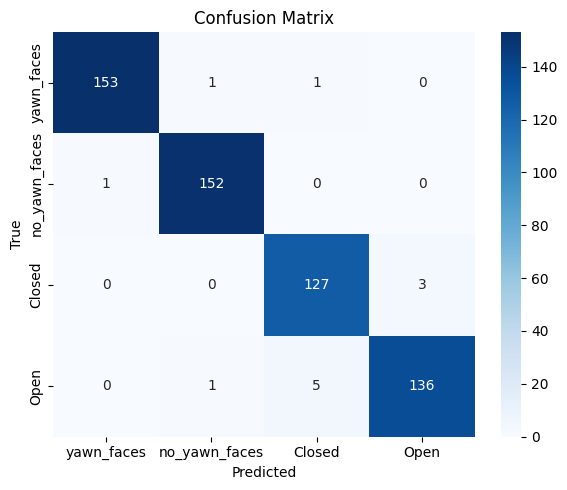

array([[153,   1,   1,   0],
       [  1, 152,   0,   0],
       [  0,   0, 127,   3],
       [  0,   1,   5, 136]], dtype=int64)

In [35]:
class_names = [ 'yawn_faces','no_yawn_faces','Closed','Open'] 
evaluate_classification_metrics(model, test_loader, device, class_names)